System information (for reproducibility):

In [106]:
versioninfo()

Julia Version 1.11.5
Commit 760b2e5b739 (2025-04-14 06:53 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (arm64-apple-darwin24.0.0)
  CPU: 12 × Apple M2 Max
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, apple-m2)
Threads: 8 default, 0 interactive, 4 GC (on 8 virtual cores)
Environment:
  JULIA_NUM_THREADS = 8
  JULIA_EDITOR = code


Load packages:

In [107]:
using Pkg

Pkg.activate(pwd())
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Documents/github.com/ucla-biostat-257/2025spring/slides/22-juliaopt`


Status `~/Documents/github.com/ucla-biostat-257/2025spring/slides/22-juliaopt/Project.toml`
  [1e616198] COSMO v0.8.9
  [13f3f980] CairoMakie v0.13.5
  [61c947e1] Clarabel v0.10.0
  [f65535da] Convex v0.16.4
  [31c24e10] Distributions v0.25.120
  [5789e2e9] FileIO v1.17.0
⌅ [f6369f11] ForwardDiff v0.10.38
  [2e9cd046] Gurobi v1.7.4
  [b99e6be6] Hypatia v0.8.2
  [916415d5] Images v0.26.2
  [b6b21f68] Ipopt v1.10.3
  [4076af6c] JuMP v1.25.0
  [2ddba703] Juniper v0.9.3
  [b8f27783] MathOptInterface v1.40.0
  [1ec41992] MosekTools v0.15.9
  [7f7a1694] Optimization v4.2.0
  [fd9f6733] OptimizationMOI v0.5.3
  [4e6fcdb7] OptimizationNLopt v0.3.2
  [36348300] OptimizationOptimJL v0.4.3
  [c946c3f1] SCS v2.1.0
  [276daf66] SpecialFunctions v2.5.1
  [10745b16] Statistics v1.11.1
  [37e2e46d] LinearAlgebra v1.11.0
  [9a3f8284] Random v1.11.0
  [2f01184e] SparseArrays v1.11.0
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see

# Optimization in Julia

This lecture gives an overview of some optimization tools in Julia.

## Flowchart

* Statisticians do optimizations in daily life: maximum likelihood estimation, machine learning, ...

* Category of optimization problems:

    1. Problems with analytical solutions: least squares, principle component analysis, canonical correlation analysis, ...
    
    2. Problems subject to Disciplined Convex Programming (DCP): linear programming (LP), quadratic programming (QP), second-order cone programming (SOCP), semidefinite programming (SDP), and geometric programming (GP).
    
    3. Nonlinear programming (NLP): Newton type algorithms, Fisher scoring algorithm, EM algorithm, MM algorithms. 
    
    4. Large scale optimization: ADMM, SGD, ...
    
![Flowchart](./optimization_flowchart.png)

## Modeling tools and solvers

Getting familiar with **good** optimization softwares broadens the scope and scale of problems we are able to solve in statistics. Following table lists some of the best optimization softwares. 


|           |   | LP | MILP | SOCP |     MISOCP     | SDP | GP | NLP | MINLP |   | R | Matlab | Julia | Python |   | Cost |  
|:---------:|:-:|:--:|:----:|:----:|:--------------:|:---:|:--:|:---:|:-----:|:-:|:-:|:------:|:-----:|:------:|:-:|:----:|  
|   **modeling tools**   |   |    |      |      |                |     |    |     |       |   |   |        |       |        |   |      |  
|    cvx    |   |  x |   x  |   x  |        x       |  x  |  x |     |       |   | x |    x   |       |    x   |   |   A  |  
| Convex.jl |   |  x |   x  |   x  |        x       |  x  |    |     |       |   |   |        |   x   |        |   |   O  |  
|  Optimization.jl  |   |  x |   x  |   x  |        x       |     |    |  x  |   x   |   |   |        |   x   |        |   |   O  |  
|  JuMP.jl  |   |  x |   x  |   x  |        x       |     |    |  x  |   x   |   |   |        |   x   |        |   |   O  |  
| MathOptInterface.jl |   |  x |   x  |   x  |        x       |     |    |  x  |   x   |   |   |        |   x   |        |   |   O  |  
|   **convex solvers** |   |    |      |      |                |     |    |     |       |   |   |        |       |        |   |      |  
|   Mosek   |   |  x |   x  |   x  |        x       |  x  |  x |  x  |       |   | x |    x   |   x   |    x   |   |   A  |  
|   Gurobi  |   |  x |   x  |   x  |        x       |     |    |     |       |   | x |    x   |   x   |    x   |   |   A  |  
|   CPLEX   |   |  x |   x  |   x  |        x       |     |    |     |       |   | x |    x   |   x   |    x   |   |   A  |  
|    SCS    |   |  x |      |   x  |                |  x  |    |     |       |   |   |    x   |   x   |    x   |   |   O  |  
|    COSMO.jl    |  |  x |  |  x |              |  x  |    |     |       |   |   |     |   x   |     |   |   O  |  
|    Hypatia.jl (more cones)   |  |  x |  |  x |              |  x  |    |     |       |   |   |     |   x   |     |   |   O  |   
|   **NLP solvers**  |   |    |      |      |                |     |    |     |       |   |   |        |       |        |   |      |  
|   NLopt   |   |  x |      |      |                |     |    |  x  |       |   | x |    x   |   x   |    x   |   |   O  |  
|   Ipopt   |   |  x |      |      |                |     |    |  x  |       |   | x |    x   |   x   |    x   |   |   O  |  
|   KNITRO  |   |  x |   x  |      |                |     |    |  x  |   x   |   | x |    x   |   x   |    x   |   |   $  |  

    O: open source, A: free academic license, $: commercial

* For more extended list of solvers, see [here](https://jump.dev/JuMP.jl/stable/installation/#Supported-solvers).

* Difference between **modeling tool** and **solvers**

    - **Modeling tools** such as cvx (for Matlab) and Convex.jl (Julia analog of cvx) implement the disciplined convex programming (DCP) paradigm proposed by Grant and Boyd (2008) <http://stanford.edu/~boyd/papers/disc_cvx_prog.html>. DCP prescribes a set of simple rules from which users can construct convex optimization problems easily.
    
    - **Solvers** (Mosek, Gurobi, Cplex, SCS, COSMO, Hypatia, ...) are concrete software implementation of optimization algorithms. My favorite ones are: Mosek/Gurobi/SCS for DCP and Ipopt/NLopt for nonlinear programming. Mosek and Gurobi are commercial software but free for academic use. SCS/Ipopt/NLopt are open source.  
    
    - Modeling tools usually have the capability to use a variety of solvers. But modeling tools are solver agnostic so users do not have to worry about specific solver interface.
    
* If you want to install the commercial solvers Gurobi or Mosek, instructions are below:
    - Gurobi: 1. Download Gurobi at [link](https://www.gurobi.com/downloads/gurobi-software/). 2. Register an account and request free academic license at [link](https://portal.gurobi.com/iam/register/). 3. Run `grbgetkey XXXXXXXXX` command on terminal as suggested. It'll retrieve a license file and put it under a specified folder, e.g., `/Users/huazhou/Documents/Gurobi/gurobi.lic`. 4. Set up the environmental variables. On my machine, I put following two lines in the `~/.julia/config/startup.jl` file: `ENV["GUROBI_HOME"] = "/Library/gurobi1201/macos_universal2"` and `ENV["GRB_LICENSE_FILE"] = "/Users/huazhou/Documents/Gurobi/gurobi.lic"`.  
    - Mosek: 1. Request free academic license at [link](https://www.mosek.com/products/academic-licenses/). The license file will be sent to your edu email within minutes. Check Spam folder if necessary. 2. Put the license file at the default location `~/mosek/`.
    - Install Julia packages Convex.jl, SCS.jl, Gurobi.jl, Mosek.jl, MathProgBase.jl, NLopt.jl, Ipopt.jl, which are open source.

## DCP Using Convex.jl

Standard convex problem classes like LP (linear programming), QP (quadratic programming), SOCP (second-order cone programming), SDP (semidefinite programming), and GP (geometric programming), are becoming a **technology**.

![DCP Hierarchy](./convex-hierarchy.png)

### Example: microbiome regression analysis

We illustrate optimization tools in Julia using microbiome analysis as an example.

16S microbiome sequencing techonology generates sequence counts of various organisms (OTUs, operational taxonomic units) in samples. 

![Microbiome Data](./microbiome_data.png)

For statistical analysis, counts are normalized into **proportions** for each sample, resulting in a covariate matrix $\mathbf{X}$ with all rows summing to 1. For identifiability, we need to add a sum-to-zero constraint to the regression cofficients. In other words, we need to solve a **constrained least squares problem**  
$$
    \text{minimize} \frac{1}{2} \|\mathbf{y} - \mathbf{X} \beta\|_2^2
$$
subject to the constraint $\sum_{j=1}^p \beta_j = 0$. For simplicity we ignore intercept and non-OTU covariates in this presentation.

Let's first generate an artifical data set.

In [108]:
using Random, LinearAlgebra, SparseArrays

Random.seed!(257) # seed

n, p = 100, 50
X = rand(n, p)
# scale each row of X sum to 1
lmul!(Diagonal(1 ./ vec(sum(X, dims=2))), X)
# true β is a sparse vector with about 10% non-zero entries
β = sprandn(p, 0.1) 
y = X * β + randn(n);

### Sum-to-zero regression

The sum-to-zero contrained least squares is a standard quadratic programming (QP) problem so should be solved easily by any QP solver.

#### Modeling using Convex.jl

We use the Convex.jl package to model this QP problem. For a complete list of operations supported by Convex.jl, see <https://jump.dev/Convex.jl/stable/operations/>.

In [109]:
using Convex

β̂cls = Variable(size(X, 2))
problem = minimize(0.5sumsquares(y - X * β̂cls)) # objective
problem.constraints = [sum(β̂cls) == 0]; # constraint
problem

Problem statistics
  problem is DCP         : true
  number of variables    : 1 (50 scalar elements)
  number of constraints  : 1 (1 scalar elements)
  number of coefficients : 5_103
  number of atoms        : 7

Solution summary
  termination status : OPTIMIZE_NOT_CALLED
  primal status      : NO_SOLUTION
  dual status        : NO_SOLUTION

Expression graph
  minimize
   └─ * (convex; positive)
      ├─ [0.5;;]
      └─ qol (convex; positive)
         ├─ + (affine; real)
         │  ├─ …
         │  └─ …
         └─ [1;;]
  subject to
   └─ == constraint (affine)
      └─ + (affine; real)
         ├─ sum (affine; real)
         │  └─ …
         └─ [0;;]


#### Mosek

We first use the Mosek solver to solve this QP.

In [110]:
using MosekTools, MathOptInterface
const MOI = MathOptInterface

solver = MOI.OptimizerWithAttributes(Mosek.Optimizer, "LOG" => 1)

@time solve!(problem, solver)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1               
  Affine conic cons.     : 1 (102 rows)
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 51              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - dual attempts          : 0               

[ Info: [Convex.jl] Compilation finished: 0.0 seconds, 2.256 MiB of memory allocated


Problem statistics
  problem is DCP         : true
  number of variables    : 1 (50 scalar elements)
  number of constraints  : 1 (1 scalar elements)
  number of coefficients : 5_103
  number of atoms        : 7

Solution summary
  termination status : OPTIMAL
  primal status      : FEASIBLE_POINT
  dual status        : FEASIBLE_POINT
  objective value    : 28.8467

Expression graph
  minimize
   └─ * (convex; positive)
      ├─ [0.5;;]
      └─ qol (convex; positive)
         ├─ + (affine; real)
         │  ├─ …
         │  └─ …
         └─ [1;;]
  subject to
   └─ == constraint (affine)
      └─ + (affine; real)
         ├─ sum (affine; real)
         │  └─ …
         └─ [0;;]


In [111]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 28.846723126126648, [5.50999308911286; 2.3835671892547334; … ; -3.5233708752162136; -14.863428523256783;;])

In [112]:
# check constraint satisfication
sum(β̂cls.value)

2.4868995751603507e-13

#### Gurobi

Switch to Gurobi solver:

In [113]:
using Gurobi

solver = MOI.OptimizerWithAttributes(Gurobi.Optimizer, "OutputFlag" => 1)

@time solve!(problem, solver)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-15
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 103 rows, 153 columns and 5155 nonzeros
Model fingerprint: 0xceaf534d
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [3e-05, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-01, 5e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 3e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 102 rows, 152 columns, 5152 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 50
 AA' NZ     : 5.150e+03
 Factor NZ  : 5.253e+03
 Factor Ops : 3.590e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objec

[ Info: [Convex.jl] Compilation finished: 0.01 seconds, 6.649 MiB of memory allocated


Problem statistics
  problem is DCP         : true
  number of variables    : 1 (50 scalar elements)
  number of constraints  : 1 (1 scalar elements)
  number of coefficients : 5_103
  number of atoms        : 7

Solution summary
  termination status : OPTIMAL
  primal status      : FEASIBLE_POINT
  dual status        : NO_SOLUTION
  objective value    : 28.8467

Expression graph
  minimize
   └─ * (convex; positive)
      ├─ [0.5;;]
      └─ qol (convex; positive)
         ├─ + (affine; real)
         │  ├─ …
         │  └─ …
         └─ [1;;]
  subject to
   └─ == constraint (affine)
      └─ + (affine; real)
         ├─ sum (affine; real)
         │  └─ …
         └─ [0;;]


In [114]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 28.84672474228832, [5.510457528212885; 2.3837733033643653; … ; -3.523669336789277; -14.864701503734674;;])

In [115]:
# check constraint satisfication
sum(β̂cls.value)

-1.0231815394945443e-12

#### COSMO

Switch to [COSMO solver](https://github.com/oxfordcontrol/COSMO.jl) (pure Julia implementation):

In [116]:
# Use COSMO solver
using COSMO

solver = MOI.OptimizerWithAttributes(COSMO.Optimizer, "max_iter" => 50_000, "verbose" => false)

@time solve!(problem, solver)

  0.319794 seconds (531.85 k allocations: 110.897 MiB, 4.14% gc time, 10.95% compilation time: 100% of which was recompilation)


[ Info: [Convex.jl] Compilation finished: 0.03 seconds, 3.366 MiB of memory allocated


Problem statistics
  problem is DCP         : true
  number of variables    : 1 (50 scalar elements)
  number of constraints  : 1 (1 scalar elements)
  number of coefficients : 5_103
  number of atoms        : 7

Solution summary
  termination status : OPTIMAL
  primal status      : FEASIBLE_POINT
  dual status        : FEASIBLE_POINT
  objective value    : 28.8809

Expression graph
  minimize
   └─ * (convex; positive)
      ├─ [0.5;;]
      └─ qol (convex; positive)
         ├─ + (affine; real)
         │  ├─ …
         │  └─ …
         └─ [1;;]
  subject to
   └─ == constraint (affine)
      └─ + (affine; real)
         ├─ sum (affine; real)
         │  └─ …
         └─ [0;;]


In [117]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 28.880882002894065, [5.509993060139416; 2.383567050955549; … ; -3.523370764002651; -14.863428540284978;;])

We see COSMO have a looser criterion for constraint satisfication, resulting a lower objective value.

In [118]:
sum(β̂cls.value)

2.444553715008624e-7

#### SCS

Switch to the open source [SCS solver](https://github.com/jump-dev/SCS.jl):

In [119]:
# Use SCS solver
using SCS

solver = MOI.OptimizerWithAttributes(SCS.Optimizer, "verbose" => 5000)

@time solve!(problem, solver)

------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 51, constraints m: 103
cones: 	  z: primal zero / dual free vars: 1
	  q: soc vars: 102, qsize: 1
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
	  compiled with openmp parallelization enabled
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 5052, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 8.17e+00  3.65e+00  3.88e+01  1.86e+01  1.00e-01  4.70e-04 
   250| 1.53e-03  1.61e-04  8.02e-02  2.88e+01 

[ Info: [Convex.jl] Compilation finished: 0.0 seconds, 2.394 MiB of memory allocated


Problem statistics
  problem is DCP         : true
  number of variables    : 1 (50 scalar elements)
  number of constraints  : 1 (1 scalar elements)
  number of coefficients : 5_103
  number of atoms        : 7

Solution summary
  termination status : OPTIMAL
  primal status      : FEASIBLE_POINT
  dual status        : FEASIBLE_POINT
  objective value    : 28.8467

Expression graph
  minimize
   └─ * (convex; positive)
      ├─ [0.5;;]
      └─ qol (convex; positive)
         ├─ + (affine; real)
         │  ├─ …
         │  └─ …
         └─ [1;;]
  subject to
   └─ == constraint (affine)
      └─ + (affine; real)
         ├─ sum (affine; real)
         │  └─ …
         └─ [0;;]


In [120]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 28.846724444532505, [5.509993089050771; 2.3835671885418215; … ; -3.523370874675494; -14.863428523247924;;])

In [121]:
# check constraint satisfication
sum(β̂cls.value)

1.3278267374516872e-9

#### Hypatia

Switch to the open source [Hypatia](https://github.com/jump-dev/Hypatia.jl) (pure Julia) solver:

In [122]:
# Use Hypatia solver
using Hypatia

solver = MOI.OptimizerWithAttributes(Hypatia.Optimizer, "verbose" => 1)

@time solve!(problem, solver)


 iter        p_obj        d_obj |  abs_gap    x_feas    z_feas |      tau       kap        mu | dir_res     prox  step     alpha
    0   8.5628e-01  -2.9196e-01 | 2.00e+00  5.59e-02  5.59e-01 | 1.00e+00  1.00e+00  1.00e+00 |
    1   4.3997e+00   7.8189e+00 | 1.45e-01  3.04e-02  3.04e-01 | 1.84e-01  8.43e-01  1.00e-01 | 5.3e-15  5.5e-01  co-a  9.00e-01
    2   1.4279e+01   2.2121e+01 | 1.07e-02  1.19e-02  1.19e-01 | 4.70e-02  3.90e-01  9.67e-03 | 8.9e-16  8.9e-01  co-a  9.00e-01
    3   2.3867e+01   2.7924e+01 | 1.80e-03  3.59e-03  3.59e-02 | 2.34e-02  9.81e-02  1.36e-03 | 3.9e-16  6.8e-01  co-a  8.50e-01
    4   2.8645e+01   2.8834e+01 | 4.44e-05  1.31e-04  1.31e-03 | 1.92e-02  3.73e-03  3.86e-05 | 1.6e-15  8.5e-01  co-a  9.70e-01
    5   2.8845e+01   2.8846e+01 | 8.85e-07  1.29e-06  1.29e-05 | 1.96e-02  1.53e-05  3.95e-07 | 4.9e-16  3.3e-01  co-a  9.90e-01
    6   2.8847e+01   2.8847e+01 | 8.17e-09  1.42e-08  1.42e-07 | 1.77e-02  1.44e-07  3.57e-09 | 9.7e-13  6.5e-01  co-a  9.90e-01


[ Info: [Convex.jl] Compilation finished: 0.0 seconds, 1.732 MiB of memory allocated


Problem statistics
  problem is DCP         : true
  number of variables    : 1 (50 scalar elements)
  number of constraints  : 1 (1 scalar elements)
  number of coefficients : 5_103
  number of atoms        : 7

Solution summary
  termination status : OPTIMAL
  primal status      : FEASIBLE_POINT
  dual status        : FEASIBLE_POINT
  objective value    : 28.8467

Expression graph
  minimize
   └─ * (convex; positive)
      ├─ [0.5;;]
      └─ qol (convex; positive)
         ├─ + (affine; real)
         │  ├─ …
         │  └─ …
         └─ [1;;]
  subject to
   └─ == constraint (affine)
      └─ + (affine; real)
         ├─ sum (affine; real)
         │  └─ …
         └─ [0;;]


In [123]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 28.84672311024055, [5.509993088754246; 2.3835671898357353; … ; -3.523370874921378; -14.863428523366206;;])

In [124]:
# check constraint satisfication
sum(β̂cls.value)

0.0

#### Clarabel

Switch to the open source [Clarabel](https://github.com/oxfordcontrol/Clarabel.jl) (pure Julia) solver:

In [125]:
# Use Hypatia solver
using Clarabel

solver = MOI.OptimizerWithAttributes(Clarabel.Optimizer)

@time solve!(problem, solver)

[ Info: [Convex.jl] Compilation finished: 0.02 seconds, 3.069 MiB of memory allocated


-------------------------------------------------------------
           Clarabel.jl v0.10.0  -  Clever Acronym              
                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 51
  constraints   = 103
  nnz(P)        = 0
  nnz(A)        = 5052
  cones (total) = 2
    : Zero        = 1,  numel = 1
    : SecondOrder = 1,  numel = 102

settings:
  linear algebra: direct / qdldl, precision: Float64
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-08, tol_gap_abs = 1.0e-08, tol_gap_rel = 1.0e-08,
  static reg : on, ϵ1 = 1.0e-08, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e-07
  iter refine: on, reltol = 1.0e-13, abstol = 1.0e-12, 
               max iter = 10, stop ratio = 5.0
  equilibrate: on, min_scale = 1.0e-04, max_scale = 1.0e+04
               max iter = 10

iter    pcost        dcost       

Problem statistics
  problem is DCP         : true
  number of variables    : 1 (50 scalar elements)
  number of constraints  : 1 (1 scalar elements)
  number of coefficients : 5_103
  number of atoms        : 7

Solution summary
  termination status : OPTIMAL
  primal status      : FEASIBLE_POINT
  dual status        : FEASIBLE_POINT
  objective value    : 28.8467

Expression graph
  minimize
   └─ * (convex; positive)
      ├─ [0.5;;]
      └─ qol (convex; positive)
         ├─ + (affine; real)
         │  ├─ …
         │  └─ …
         └─ [1;;]
  subject to
   └─ == constraint (affine)
      └─ + (affine; real)
         ├─ sum (affine; real)
         │  └─ …
         └─ [0;;]


In [126]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 28.846723012739073, [5.509993089173661; 2.3835671892605546; … ; -3.52337087522751; -14.86342852323002;;])

In [127]:
# check constraint satisfication
sum(β̂cls.value)

-7.105427357601002e-15

### Sum-to-zero lasso

Suppose we want to know which organisms (OTU) are associated with the response. We can answer this question using a sum-to-zero contrained lasso
$$
    \text{minimize} \frac 12 \|\mathbf{y} - \mathbf{X} \beta\|_2^2 + \lambda \|\beta\|_1
$$
subject to the constraint $\sum_{j=1}^p \beta_j = 0$. Varying $\lambda$ from small to large values will generate a solution path.

In [128]:
using Convex

# # Use Mosek solver
# using Mosek
# solver = Mosek.Optimizer

# # Use Gurobi solver
# using Gurobi
# solver = Gurobi.Optimizer

# # Use SCS solver
# using SCS
# solver = SCS.Optimizer

# Use Hypatia solver
using Hypatia
solver = Hypatia.Optimizer

# # Use Clarabel solver
# using Clarabel
# solver = Clarabel.Optimizer

# solve at a grid of λ
λgrid = 0:0.01:0.35

# holder for solution path
β̂path = zeros(length(λgrid), size(X, 2)) # each row is β̂ at a λ
# optimization variable
β̂classo = Variable(size(X, 2))
# obtain solution path using warm start
@time for i in 1:length(λgrid)
    λ = λgrid[i]
    # define optimization problem
    # objective
    problem = minimize(0.5sumsquares(y - X * β̂classo) + λ * sum(abs, β̂classo))
    # constraint
    problem.constraints += sum(β̂classo) == 0 # constraint
    solve!(problem, solver; silent = true)
    β̂path[i, :] = β̂classo.value
end

  0.516054 seconds (1.37 M allocations: 219.045 MiB, 8.30% gc time, 7.80% compilation time: 100% of which was recompilation)


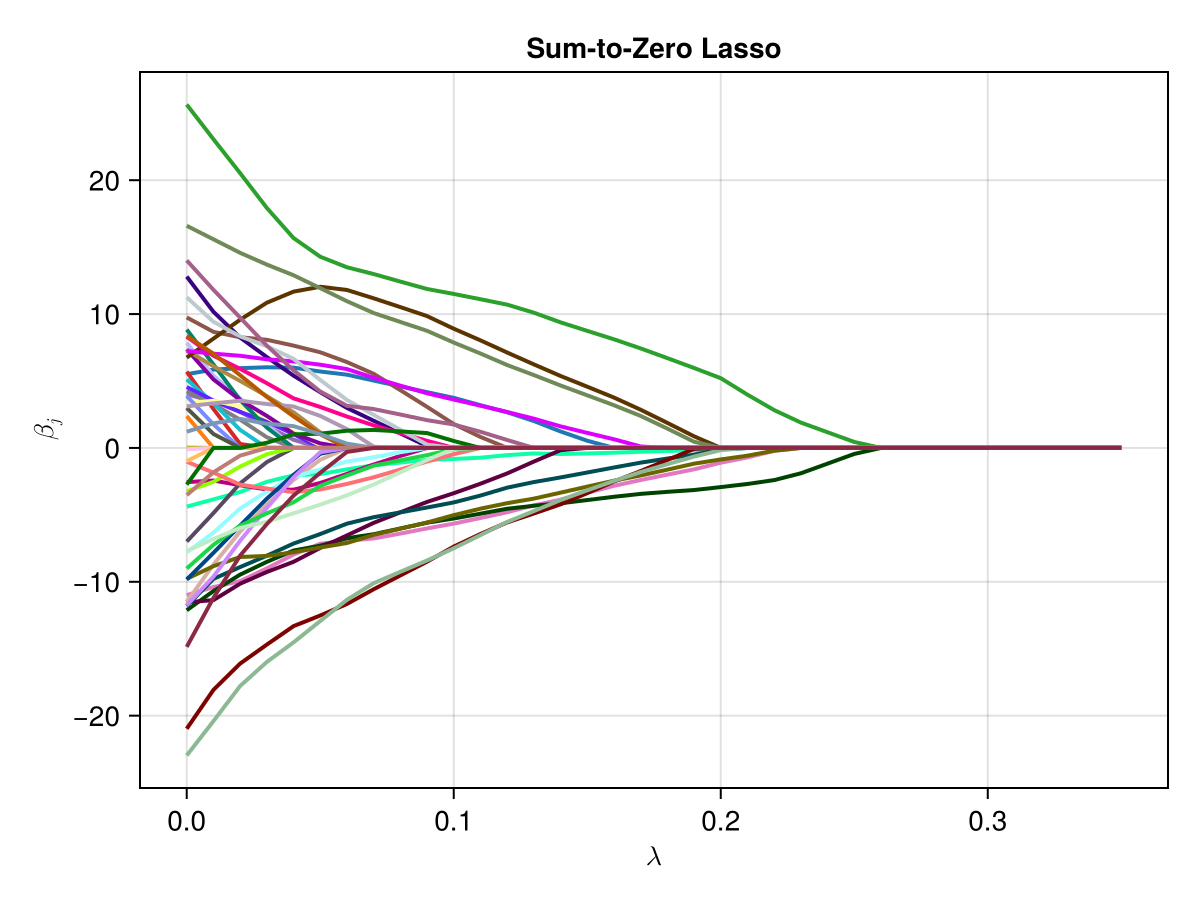

In [129]:
using CairoMakie

f = Figure()
Axis(
    f[1, 1], 
    title = "Sum-to-Zero Lasso",
    xlabel = L"\lambda",
    ylabel = L"\beta_j"
)
series!(λgrid, β̂path', color = :glasbey_category10_n256)
f

### Sum-to-zero group lasso

Suppose we want to do variable selection not at the OTU level, but at the Phylum level. OTUs are clustered into various Phyla. We can answer this question using a sum-to-zero contrained group lasso
$$
    \text{minimize} \frac 12 \|\mathbf{y} - \mathbf{X} \beta\|_2^2 + \lambda \sum_j \|\mathbf{\beta}_j\|_2
$$
subject to the constraint $\sum_{j=1}^p \beta_j = 0$, where $\mathbf{\beta}_j$ are regression coefficients corresponding to the $j$-th phylum. This is a second-order cone programming (SOCP) problem readily modeled by Convex.jl.

Let's assume each 10 contiguous OTUs belong to one Phylum.

In [130]:
# # Use Mosek solver
# using Mosek
# solver = Mosek.Optimizer

# # Use Gurobi solver
# using Gurobi
# solver = Gurobi.Optimizer

# # Use SCS solver
# using SCS
# solver = SCS.Optimizer

# Use Hypatia solver
using Hypatia
solver = Hypatia.Optimizer

# # Use Clarabel solver
# using Clarabel
# solver = Clarabel.Optimizer

# solve at a grid of λ
λgrid = 0.0:0.005:0.5
β̂pathgrp = zeros(length(λgrid), size(X, 2)) # each row is β̂ at a λ
β̂classo = Variable(size(X, 2))
@time for i in 1:length(λgrid)
    λ = λgrid[i]
    # loss
    obj = 0.5sumsquares(y - X * β̂classo)
    # group lasso penalty term
    for j in 1:(size(X, 2) ÷ 10)
        βj = β̂classo[(10(j - 1) + 1) : 10j]
        obj = obj + λ * norm(βj)
    end
    problem = minimize(obj)
    # constraint
    problem.constraints = [sum(β̂classo) == 0] # constraint
    solve!(problem, solver; silent = true)
    β̂pathgrp[i, :] = β̂classo.value
end

  0.618763 seconds (2.12 M allocations: 438.603 MiB, 12.08% gc time)


We see it took Mosek <2 second to solve this seemingly hard optimization problem at **101** different $\lambda$ values.

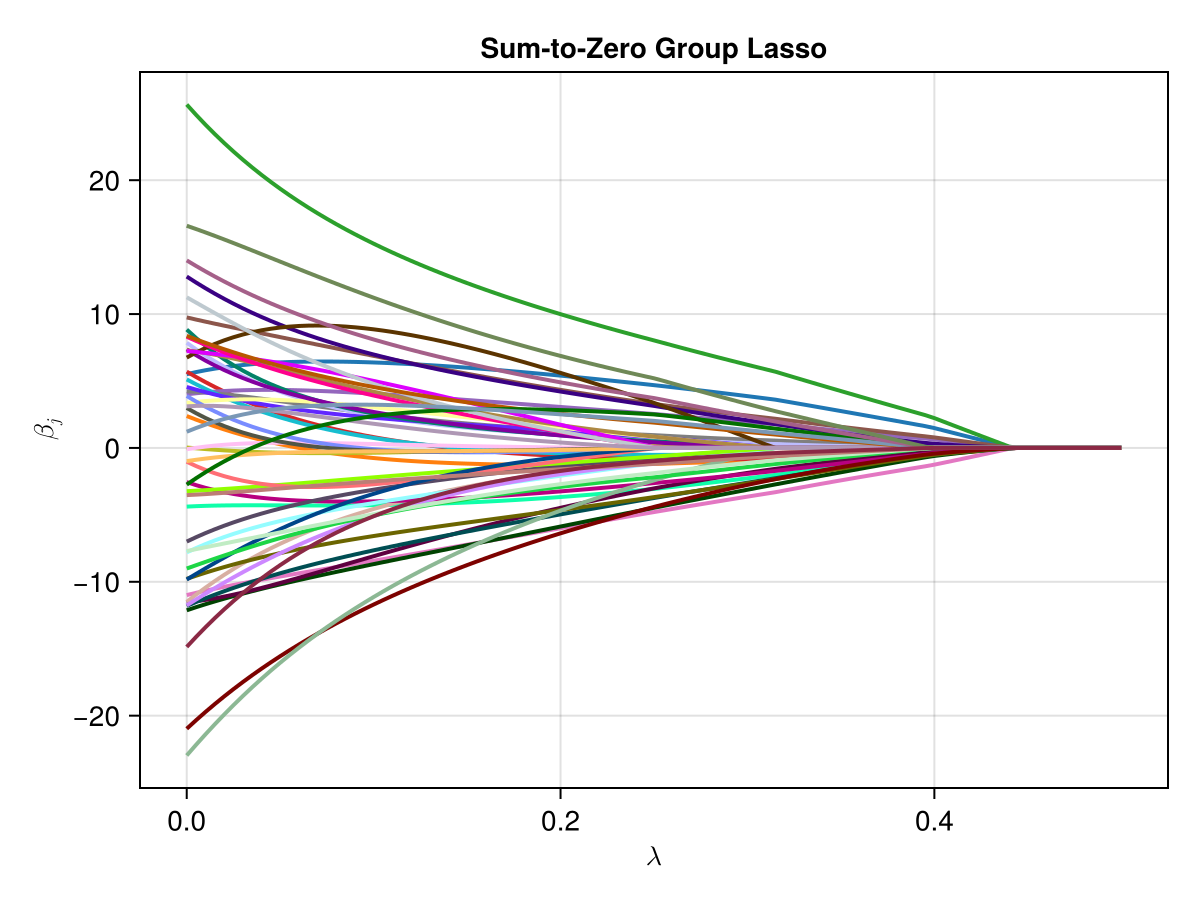

In [131]:
using CairoMakie

f = Figure()
Axis(
    f[1, 1], 
    title = "Sum-to-Zero Group Lasso",
    xlabel = L"\lambda",
    ylabel = L"\beta_j"
)
series!(λgrid, β̂pathgrp', color = :glasbey_category10_n256)
f

### Example: matrix completion

Load the $128 \times 128$ Lena picture with missing pixels.

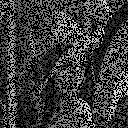

In [132]:
using FileIO

lena = load("lena128missing.png")

In [133]:
# convert to real matrices
Y = Float64.(lena)

128×128 Matrix{Float64}:
 0.0       0.0       0.635294  0.0       …  0.0       0.0       0.627451
 0.627451  0.623529  0.0       0.611765     0.0       0.0       0.388235
 0.611765  0.611765  0.0       0.0          0.403922  0.219608  0.0
 0.0       0.0       0.611765  0.0          0.223529  0.176471  0.192157
 0.611765  0.0       0.615686  0.615686     0.0       0.0       0.0
 0.0       0.0       0.0       0.619608  …  0.0       0.0       0.2
 0.607843  0.0       0.623529  0.0          0.176471  0.192157  0.0
 0.0       0.0       0.623529  0.0          0.0       0.0       0.215686
 0.619608  0.619608  0.0       0.0          0.2       0.0       0.207843
 0.0       0.0       0.635294  0.635294     0.2       0.192157  0.188235
 0.635294  0.0       0.0       0.0       …  0.192157  0.180392  0.0
 0.631373  0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.627451  0.635294  0.666667     0.172549  0.0       0.184314
 ⋮                                       ⋱  ⋮           

We fill out the missin pixels uisng a **matrix completion** technique developed by Candes and Tao
$$
    \text{minimize } \|\mathbf{X}\|_*
$$
$$
    \text{subject to } x_{ij} = y_{ij} \text{ for all observed entries } (i, j).
$$
Here $\|\mathbf{M}\|_* = \sum_i \sigma_i(\mathbf{M})$ is the nuclear norm. In words we seek the matrix with minimal nuclear norm that agrees with the observed entries. This is a semidefinite programming (SDP) problem readily modeled by Convex.jl.

This example takes longer because of high dimensionality. COSMO.jl seems to be the fastest solver for this problem. Other solvers take excessively long time.

In [134]:
# Use COSMO solver (fast)
using COSMO
solver = COSMO.Optimizer

# # Use Hypatia solver (slow)
# using Hypatia
# solver = Hypatia.Optimizer()

# # Use Clarabel solver (slow)
# using Clarabel
# solver = Clarabel.Optimizer()

# Linear indices of obs. entries
obsidx = findall(Y[:] .≠ 0.0)
# Create optimization variables
X = Variable(size(Y))
# Set up optmization problem
problem = minimize(nuclearnorm(X))
problem.constraints += X[obsidx] == Y[obsidx]
# Solve the problem by calling solve
@time solve!(problem, solver)

[ Info: [Convex.jl] Compilation finished: 0.23 seconds, 193.573 MiB of memory allocated


------------------------------------------------------------------
          COSMO v0.8.9 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{32897},
          constraints: A ∈ R^{41025x32897} (41281 nnz),
          matrix size to factor: 73922x73922,
          Floating-point precision: Float64
Sets:     DensePsdConeTriangle of dim: 32896 (256x256)
          ZeroSet of dim: 8128
          Nonnegatives of dim: 1
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemory,	
          Safeguarded

Problem statistics
  problem is DCP         : true
  number of variables    : 1 (16_384 scalar elements)
  number of constraints  : 1 (8_128 scalar elements)
  number of coefficients : 8_128
  number of atoms        : 3

Solution summary
  termination status : OPTIMAL
  primal status      : FEASIBLE_POINT
  dual status        : FEASIBLE_POINT
  objective value    : 147.9711

Expression graph
  minimize
   └─ nuclearnorm (convex; positive)
      └─ 128×128 real variable (id: 420…982)
  subject to
   └─ == constraint (affine)
      └─ + (affine; real)
         ├─ index (affine; real)
         │  └─ …
         └─ 8128×1 Matrix{Float64}


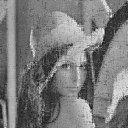

In [135]:
using Images

# Result by nuclear norm minimization
colorview(Gray, X.value)

We can also complete the matrix by the nonnegative matrix factorization (NMF) approach. The NMF problem is a non-convex optimization problem. 
$$
\text{minimize} \|P_{\Omega}(\mathbf{Y}) - P_{\Omega}(\mathbf{V}\mathbf{W})\|_F^2
$$
$$
\text{subject to } \mathbf{V} \geq 0, \mathbf{W} \geq 0
$$
where $P_{\Omega}(\mathbf{Y})$ is the projection of $\mathbf{Y}$ onto the observed entries $\Omega$. The NMF problem is a non-convex optimization problem because it has multiple local optima. However, it can be solved using alternating least squares (ALS) or multiplicative update rules. The ALS algorithm is a popular method for solving the NMF problem. It alternates between fixing one variable and solving for the other, and vice versa.

In [136]:
function mc_by_nnmf(Y, r; solver = SCS.Optimizer)
    # Linear indices of obs. entries
    obsidx = findall(Y[:] .≠ 0.0)
    yobs = Y[obsidx]
    # Create optimization variables
    V = Variable(size(Y, 1), r)
    W = Variable(r, size(Y, 2))
    # Set up optmization problem
    problem = minimize(norm(yobs - (V * W)[obsidx]), [V >= 0, W >= 0])
    # Initialize value of W
    set_value!(W, rand(r, size(Y, 2)))
    # We'll do 10 iterations of alternating minimization
    for iter in 1:20
        # Solve for V, with W fixed
        fix!(W)
        solve!(problem, solver; warmstart = iter > 1 ? true : false, silent = true)
        free!(W)
        # Solve for W, with V fixed
        fix!(V)
        solve!(problem, solver; warmstart = true, silent = true)
        free!(V)
    end
    # Return the solution
    return V.value, W.value
end

mc_by_nnmf (generic function with 1 method)

In [137]:
V, W = mc_by_nnmf(Y, 30; solver = Gurobi.Optimizer)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-15
Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-15
Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-15
Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-15
Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-15
Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-15
Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-15
Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-15
Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-15
Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-15
Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-15

([0.03558936365695675 0.09963359790567292 … 0.001807424224772325 2.8542616835645243e-11; 0.01885998122844864 0.12714463761475492 … 0.00562394905294704 3.358410961702319e-10; … ; 0.050942574505134605 0.006123770500843592 … 0.10524562898251237 0.08774136866099994; 0.07223482340443767 0.010225933560439444 … 0.11667564009521098 0.09297504327476738], [0.6636404981012094 0.2169827368432252 … 0.3268122809244541 1.9189964304527554; 0.583010787675328 1.2629974910345814 … 9.711047381150691e-10 0.06543190569928403; … ; 0.44883297716563164 0.43641935398670023 … 1.5998200137167535e-9 9.49988388078683e-8; 6.226170617867564e-10 4.2629100916064024e-9 … 0.14559006387260917 0.40718501213557473])

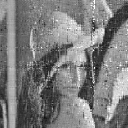

In [138]:
# Result by NNMF
colorview(Gray, V * W)

## Nonlinear programming (NLP)

We use MLE of Gamma distribution to illustrate some rudiments of nonlinear programming (NLP) in Julia. 

Let $x_1,\ldots,x_m$ be a random sample from the gamma density
$$
f(x) = \Gamma(\alpha)^{-1} \beta^{\alpha} x^{\alpha-1} e^{-\beta x}
$$
on $(0,\infty)$. The loglikelihood function is
$$
    L(\alpha, \beta) = m [- \ln \Gamma(\alpha) + \alpha \ln \beta + (\alpha - 1)\overline{\ln x} - \beta \bar x],
$$
where $\overline{x} = \frac{1}{m} \sum_{i=1}^m x_i$ and 
$\overline{\ln x} = \frac{1}{m} \sum_{i=1}^m \ln x_i$.

### Define NLP optimization problem using Optimization.jl

In [139]:
using Distributions, Optimization, Random, Statistics, SpecialFunctions

Random.seed!(257)

# θ = (α, β)
function gamma_logpdf(x::Vector{<:Real}, θ::Vector{<:Real})
    m = length(x)
    avg = mean(x)
    α, β = θ[1], θ[2]
    logavg = sum(log, x) / m
    m * (- log(gamma(α)) + α * log(β) + (α - 1) * logavg - β * avg)
end

# test data
x = rand(5)
gamma_logpdf(x, [1.0, 1.0])

-3.3064167958026847

Generate data.

In [140]:
Random.seed!(257)

(n, p) = (1000, 2)
(α, β) = 5rand(p)
x = rand(Gamma(α, β), n)
println("True parameter values:")
println("α = ", α, ", β = ", β)

True parameter values:
α = 2.838860122889505, β = 4.699007334188252


We use [Optimization.jl](https://github.com/SciML/Optimization.jl) to define and solve our NLP problem.

In [141]:
using ForwardDiff, Optimization

# loss function and gradient (by auto-diff)
loss = (θ, p) -> -gamma_logpdf(x, θ)
# more auto-diff choices: https://docs.sciml.ai/Optimization/stable/API/ad/
optf = OptimizationFunction(loss, Optimization.AutoForwardDiff())
# start point
θ₀ = [1.0, 1.0]
# optimization problem
prob = OptimizationProblem(optf, θ₀, lb = [0.0, 0.0], ub = [Inf, Inf])

OptimizationProblem. In-place: true
u0: 2-element Vector{Float64}:
 1.0
 1.0

### Optim.jl solver

[List](https://docs.sciml.ai/Optimization/stable/optimization_packages/optim/) of algorithms in Optim.jl.

In [142]:
using OptimizationOptimJL

# BFGS algorithm (gradient based)
sol = solve(prob, BFGS())

retcode: Success
u: 2-element Vector{Float64}:
 2.9457402468066
 0.2170674128195337

In [143]:
# Nelder-Mead algorithm (gradient free)
sol = solve(prob, NelderMead())

retcode: Success
u: 2-element Vector{Float64}:
 2.9457349343640113
 0.217067158037371

In [144]:
# Conjugate Gradient algorithm (gradient based)
sol = solve(prob, ConjugateGradient())

retcode: Success
u: 2-element Vector{Float64}:
 2.9457402467986586
 0.21706741281893602

### NLopt.jl solver

[List](https://docs.sciml.ai/Optimization/stable/optimization_packages/nlopt/) of algorithms in OptimizationNLopt.jl.

In [145]:
using OptimizationNLopt

sol = solve(prob, NLopt.LD_LBFGS())

retcode: Success
u: 2-element Vector{Float64}:
 2.945740246710059
 0.21706741281080016

### MathOptInterface.jl solver

[List](https://docs.sciml.ai/Optimization/stable/optimization_packages/mathoptinterface/) of algorithms in OptimizationMOI.jl.

In [146]:
using OptimizationMOI, Ipopt

# Ipopt
sol = solve(prob, Ipopt.Optimizer())


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

retcode: Success
u: 2-element Vector{Float64}:
 2.945740250057661
 0.2170674130823058